[![image-1.png](https://i.postimg.cc/HxFJ6c1w/image-1.png)](https://postimg.cc/XGc7JvJq)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Определение жанра по обложки музыкального диска</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 

    
Очевидно, что оформление музыкального альбома как-то связано с его содержанием. Но насколько связано? Как подтвердить это, опираясь на данные? И чем это может быть полезно?

__Постановка задачи:__ разработать модель, которая определит жанр музыкального альбома по изображению его обложки..
    
__Описание данных:__ Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек одного из десяти жанров:
    
   - anime
   - black metal
   - classical
   - country
   - disco
   - edm
   - jazz
   - pop
   - rap 
   - reggae
    

__Оценка результата:__  Accuracy, Precision, Recall, F1.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [20]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from PIL import Image

# константы
RANDOM_SEED = 42
BASE_PATH = 'data/' # корневая директория
IMAGES = os.path.join(BASE_PATH, 'images') # путь к фотографиям

# настройки блокнота
random.seed(RANDOM_SEED)

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

Давайте сначала создадим набор данных, в котором будут указаны пути к изображениям, а в качестве меток (таргетов) будем использовать названия папок, отражающих жанры музыки.

In [9]:
data = []

for genre in os.listdir(IMAGES): # получаем список папок
    genre_path = os.path.join(IMAGES, genre)
    if os.path.isdir(genre_path): # проверка действительности директории
        for filename in os.listdir(genre_path):
            file_path = os.path.join(genre_path, filename)
            data.append((file_path, genre)) # добавляем полный путь и название папки (жанр)
    else: print('Ошибка в формировании пути к файлу')

df = pd.DataFrame(data, columns=['file_path', 'genre'])

display(df.head(2))

,file_path,genre
0,data/images/pop/dea7825d-5cd5-4748-9fea-76bbe7...,pop
1,data/images/pop/3694c8b3-e7c4-4b2d-aacc-6588a5...,pop


Выведем насколько изображений:

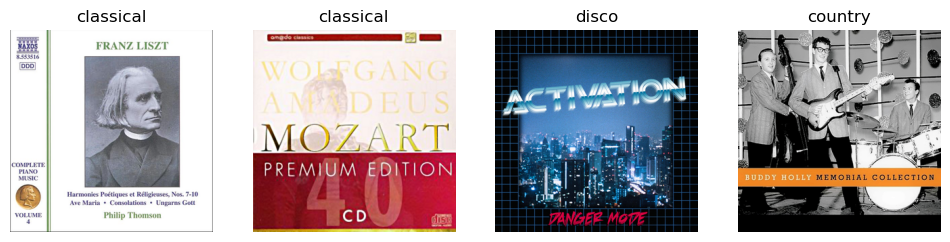

In [29]:
n_images = 4 # количество изображений

sample_images = df.sample(n_images, random_state=RANDOM_SEED) # выборка

# вывод изодражений
ig, axes = plt.subplots(1, n_images, figsize=(12, 4))
for i in range(n_images):
    image_path = sample_images.iloc[i, 0]
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{sample_images.iloc[i, 1]}')
    axes[i].axis('off')
plt.show()